In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import h5py
from math import radians
import pandas as pd
import noise

![Coaxial Cable](coax_structure.png "Coaxial Cable")

In [2]:
class cable_decay:
    # this is a description

    def __init__(self, max_freq, min_freq, channels, a, b, c, rho_in, rho_out, mu_in, mu_out, roughness, eps_dielectric,
                 rho_dielectric, mu_dielectric, tan_d, tcr_in, tcr_out, z_l):
        """
        Calculate the skin depth for a material given the associated properties.
        Parameters
        ----------
        max_freq : float
            Maximum frequency range of S_21 calculation [GHz].
        min_freq : float
            Minimum frequency range of S_21 calculation [GHz].
        channels : int
            Number of channels across specified bandwidth [Dimensionless].
        a : float
            Core radius [meters] (See diagram above).
        b : float
            Dielectric radius [meters] (See diagram above).
        c : float
            Shield radius [meters] (See diagram above).
        rho_in : float
            Core resistivity [ohm*meters].
        rho_out : float
            Shield resistivity [ohm*meters].
        mu_in : float
            Core relative permeability [dimensionless].
        mu_out : float
            Shield relative permeability [dimensionless].
        roughness : float
            Surface roughness [meters].
        eps_dielectric : float
            Dielectric relative permativity [dimensionless].
        rho_dielectric : float
            Dielectric resistivity [ohm*meters].
        mu_dielectric : float
            Dielectric relative permeability [dimensionless].
        tan_d : float
            Dielectric loss tangent [dimensionless].
        tcr_in : float
            Core tempeture Coeficient of Resistance [dimensionless].
        tcr_out : float
            Shield tempeture Coeficient of Resistance [dimensionless].
        z_l : float
            Load impedence [ohms].
        """
        self.max_freq = max_freq * 10 ** 9  # Convert GHz to Hz.
        self.min_freq = min_freq * 10 ** 9  # Convert GHz to Hz.
        self.channels = channels
        self.a = a
        self.b = b
        self.c = c
        self.rho_in = rho_in
        self.rho_out = rho_out
        self.mu_in = mu_in * 4 * np.pi * 10 ** -7  # Convert to core permeability.
        self.mu_out = mu_out * 4 * np.pi * 10 ** -7  # Convert to shield permeability.
        self.roughness = roughness
        self.eps_dielectric = eps_dielectric
        self.rho_dielectric = rho_dielectric
        self.mu_dielectric = mu_dielectric
        self.tan_d = tan_d

        # Tempeture Coeficient of Resistance:
        # https://www.allaboutcircuits.com/textbook/direct-current/chpt-12/temperature-coefficient-resistance/
        self.tcr_in = tcr_in
        self.tcr_out = tcr_out

        self.z_l = z_l

        # Create all frequency & wavelengths for calculations.
        self.frequencies = frequencies = np.linspace(self.min_freq, self.max_freq, channels)  # Hz.
        self.wavelengths = const.speed_of_light / self.frequencies  # meters.

    def skin_depth(self, frequency, mu, rho):
        """
        Calculate the skin depth for a material given the associated properties.
        Parameters
        ----------
        frequency : np.array
            Frequency [meters].
        mu : float
            Pearmeability [meters].
        rho : float
            Resistivity [meters].

        Returns
        -------
        delta : float
            Skin depth
        """
        self.delta = np.sqrt(rho / (np.pi * frequency * mu))
        return self.delta

    def skin_depth_out(self):
        """
        Calculate the skin depth for coax shielding given the associated properties.
        Returns
        -------
        delta : float
            Outer shield skin depth [meters].
        """
        self.delta_out = self.skin_depth(self.frequencies, self.mu_out, self.rho_out)
        return self.delta_out

    def skin_depth_in(self):
        """
        Calculate the skin depth for coax core given the associated properties.
        Returns
        -------
        delta : float
            Inner core skin depth [meters].
        """
        self.delta_in = self.skin_depth(self.frequencies, self.mu_in, self.rho_in)
        return self.delta_in

    def inner_conductor_equivalent_area(self):
        """
        Calculate the coax cable sheilding equivalent area.
        Returns
        -------
        core_area : float
            Coax cable core equivalent area [meters**2]
        """
        self.core_area = 2 * np.pi * self.delta_out * (self.a + self.delta_in * (np.exp(-self.a / self.delta_in) - 1))
        return self.core_area

    def outer_conductor_equivalent_area(self):
        """
        Calculate the coax cable sheilding equivalent area.
        Returns
        -------
        shield_area : float
            Coax cable core equivalent area [meters**2]
        """

        self.shield_area = 2 * np.pi * self.delta_out * (
                self.b + self.delta_out - (self.c + self.delta_out) * np.exp((self.b - self.c) / self.delta_out))
        return self.shield_area

    def surface_roughness_coeff(self):
        """
        Calculate the surface roughness coefficient as a percentage.
        Returns
        -------
        k_sr : float
            Surface roughness coefficent [%].
        """
        self.k_sr_in = 1 + (2 / np.pi) * np.arctan(1.4 * (self.roughness / self.delta_in) ** 2)
        self.k_sr_out = 1 + (2 / np.pi) * np.arctan(1.4 * (self.roughness / self.delta_out) ** 2)
        return self.k_sr_in, self.k_sr_out

    def coax_impedence(self):
        """
        Use coax equation to calculate the impedence, given donut dimensions and properties.
        Returns
        -------
        z_naught : float
            Impedance [ohms].
        """
        self.z_0 = 138 * np.log10(self.b / self.a) / (self.eps_dielectric ** 0.5)
        return self.z_0

    def loss_skin_effect(self):
        """
        Calculate losses associated with the skin effect on the coaxial cable [dB/m].
        Returns
        -------
        loss_delta : np.array(float)
            Loss due to skin effect [dB/m].
        """
        self.loss_delta_in = 8.68588 * (self.rho_in / self.core_area * self.k_sr_in) / (2 * self.z_0)
        self.loss_delta_out = 8.68588 * (self.rho_out / self.shield_area * self.k_sr_out) / (2 * self.z_0)
        self.loss_delta = self.loss_delta_in + self.loss_delta_out
        return self.loss_delta

    def loss_conductivity(self):
        """
        Loss due to conduction in coax dielectric: the only loss mechanism independent of frequency and geometry.
        Returns
        -------
        loss_sigma : np.array(float)
            Loss due to dielectric conductivity [dB/m].
        """
        loss_mhos_per_m = 2 * np.pi / self.rho_dielectric / np.log(self.b / self.a)
        self.loss_sigma = 8.686 * loss_mhos_per_m * self.z_0 / 2
        return self.loss_sigma

    def loss_dielectric_tangent(self):
        """
        Loss tangent is the ratio at any specified frequency between the real and imaginary parts of the impedance of the capacitor. A large loss tangent refers to a high degree of dielectric absorption.
        Returns
        -------
        loss_tangent : np.array(float)
            Loss due to dielectric absorption [dB/m].
        """
        self.loss_tangent = 27.28753 * np.sqrt(self.eps_dielectric) * self.tan_d * self.frequencies / const.c
        return self.loss_tangent

    def loss_thermal(self, temperature):
        """
        The resistance of the cable depends on the operating temperature and thus introdduces another source of loss.
        Parameters
        ----------
        temperature : float
            Temperture of cable operation [Kelvin].

        Returns
        -------
        self.loss_temp : np.array(float)
            Loss due to temperature dependence of resistance [dB/m].
        """
        temp_in_celcius = temperature - 273.15
        self.loss_temp = self.loss_delta_in * (1 + self.tcr_in * (temp_in_celcius - 25)) + self.loss_delta_out * (
                1 + self.tcr_out * (temp_in_celcius - 25))
        return self.loss_temp

    def cable_reflection_coefficient(self):
        """
        Calculate the reflection coefficient: describes percentage of wave reflected by an impedance discontinuity/mismatch in the transmission medium.
        Returns
        -------
        self.reflection_coeff : float
            Reflection coefficiente [dimensionless].
        """
        self.reflection_coeff = (self.z_l - self.z_0) / (self.z_l + self.z_0)
        return self.reflection_coeff

    def atennuate_signal(self, signal, length, temperature, incl_delta=True, incl_sigma=True, incl_tangent=True,
                         incl_thermal=True):
        """
        Apply selected (Skin depth effect, conductivity, tangent & thermal) attenuation to an input signal.
        Parameters
        ----------
        signal : float
            Input signal [dimensionless].
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.

        Returns
        -------
        attenuated_signal : float
            Input signal after various attenuation effects have been applied [dimensionless].
        """
        attenuation = 0

        if incl_delta == True and incl_thermal == False:
            attenuation += self.loss_delta
        if incl_sigma == True:
            attenuation += self.loss_sigma
        if incl_tangent == True:
            attenuation += self.loss_tangent
        if incl_thermal == True:
            attenuation += self.loss_thermal(temperature)

        if incl_delta == False and incl_sigma == False and incl_tangent == False and incl_thermal == False:
            return signal * np.ones(np.shape(self.frequencies))
        elif incl_delta == False and incl_sigma == True and incl_tangent == False and incl_thermal == False:
            return signal * (10 ** (-(attenuation * np.ones(np.shape(self.frequencies)) / 10) * length))
        else:
            return signal * (10 ** (-(attenuation / 10) * length))

    def cable_reflections(self, length, temperature, reflection_no, incl_delta=True, incl_sigma=True, incl_tangent=True,
                          incl_thermal=True):
        """
        Generate superposition of s_21 cable reflections for a given cable length, temperture and reflection order.
        Parameters
        ----------
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        reflection_no : int
            Number of reflections orders to be included [dimensionless].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.

        Returns
        -------
        s_21 : np.array(complex)
            Generated S_21 contribution due to nth order cable reflection.
        """

        v_g = (const.c) / np.sqrt(self.eps_dielectric * self.mu_dielectric)  # m/s
        optical_length = (-1 + 2 * reflection_no) * length
        delay = float(optical_length / v_g)  # seconds
        omega = 2 * np.pi * delay
        signal_amp = self.atennuate_signal(
            np.sin(self.frequencies * omega) * (self.reflection_coeff ** (2*reflection_no)),
            optical_length, temperature, incl_delta=incl_delta, incl_sigma=incl_sigma,
            incl_tangent=incl_tangent, incl_thermal=incl_thermal)
        signal_phase = (2 * np.pi * self.frequencies) * delay
        return [complex(signal_amp[i], signal_phase[i]) for i in range(len(signal_amp))]

    def to_real_imag(self, amp_phase):
        """
        Convert to real and imaginary components, assuming phases are in degrees.
        Parameters
        ----------
        amp_phase : np.array(complex)
            Input amplitudes & phases [dimensionless].

        Returns
        -------
        real_imag : np.array(complex)
            Real & imaginary components in rectangular complex form.
        """
        amp, phase = amp_phase.real, amp_phase.imag

        real_imag = amp * np.exp(1j * phase)
        return complex(np.real(real_imag), np.imag(real_imag))

    def to_amp_phase(self, real_imag):
        """
        Convert to amp and phase components, phases are in degrees.
        Parameters
        ----------
        real_imag : np.array(complex)
            Input real & imaginary components [dimensionless].

        Returns
        -------
        amp_phase ; np.array(complex)
            Amp & phase components in complex form.
        """
        return complex(np.abs(real_imag), np.angle(real_imag))

    def loss_with_length_freq(self, length, temperature, reflection_no, incl_delta=True, incl_sigma=True,
                              incl_tangent=True, incl_thermal=True, incl_reflections=True):
        """
        Apply selected (Skin depth effect, conductivity, tangent & thermal) attenuation to an input signal.
        Parameters
        ----------
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        reflection_no : int
            Number of reflections orders to be included [dimensionless].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.
        incl_reflections : <class 'bool'>
            Include cable reflections effect.

        Returns
        -------
        s_21: np.array(complex)
            Generated s21 for the given input parameters.
        """
        signal = self.atennuate_signal(1, length, temperature, incl_delta=incl_delta, incl_sigma=incl_sigma,
                                       incl_tangent=incl_tangent, incl_thermal=incl_thermal)
        self.cable_reflection_coefficient()

        if incl_reflections == True:
            transmittance_amp = signal - signal * self.reflection_coeff
        else:
            transmittance_amp = signal

        transmittance = [self.to_real_imag(complex(transmittance_amp[i], 0)) for i in range(len(transmittance_amp))]
        if incl_reflections is True and reflection_no != 0:
            for order in range(reflection_no):
                reflection = self.cable_reflections(length, temperature, order+1, incl_delta=incl_delta,
                                                    incl_sigma=incl_sigma,
                                                    incl_tangent=incl_tangent, incl_thermal=incl_thermal)
                transmittance = [self.to_real_imag(reflection[i]) + transmittance[i] for i in range(len(reflection))]

        s_21 = np.sqrt(np.abs(transmittance))
        phase = np.imag(self.cable_reflections(length, temperature, 1, incl_delta=incl_delta, incl_sigma=incl_sigma,
                                               incl_tangent=incl_tangent, incl_thermal=incl_thermal))
        return [complex(s_21[i], phase[i]) for i in range(len(s_21))]

In [3]:
def equirectangular_approx(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """    
    r = 6371*10**3 #radius of Earth in Meters
    
    theta_1 = lat1 * np.pi/180
    theta_2 = lat2 * np.pi/180
    delta_theta = (lat2-lat1) * np.pi/180
    delta_lam = (lon2-lon1) * np.pi/180
    
    x = np.sin(delta_lam) * np.cos(theta_2)
    y = np.cos(theta_1) * np.sin(theta_2) - (np.sin(theta_1) * np.cos(theta_2) * np.cos(delta_lam))
    phi = (np.arctan2(x, y) + 3 * np.pi) % (2*np.pi)
    

    a = np.sin(delta_theta/2)**2 + np.cos(theta_1) * np.cos(theta_2) * np.sin(delta_lam/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    rho = r * c

    return [rho, phi] # meters, degrees


def polar_to_cart(rho, phi): # meters, degrees
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return [x, y]


def get_antenna_pos():
    centre = [116.7644482, -26.82472208] # lat , lon
    station_dist_from_centre = []
    station_pos = pd.read_csv('./antenna_pos/layout_wgs84.txt', header=None, names=["latitude", "longitude"])
    station_pos['lat_rel'] = (station_pos['latitude']- centre[0] )
    station_pos['lon_rel'] = (station_pos['longitude'] - centre[1])
    station_pos['rho'], station_pos['phi'] = equirectangular_approx(station_pos['lat_rel'], station_pos['lon_rel'], 0.0, 0.0)
    station_pos['x'], station_pos['y'] = polar_to_cart(station_pos['rho'], station_pos['phi'])

    antenna_info = pd.DataFrame(columns=['station', 'x', 'y'])
    for i, x, y in zip(range(512), station_pos['x'], station_pos['y']):
        df = pd.read_csv('./antenna_pos/station' + str(i).rjust(3, '0') + '/layout.txt', header=None, names=["delta_x", "delta_y"])
        df['delta_x'], df['delta_y'] = df['delta_x']+x, df['delta_y']+y
        df['station'] = i
        df = df[['station', "delta_x", "delta_y"]]
        antenna_info = antenna_info.append(pd.DataFrame(df.to_dict('split')['data'], columns=['station', "x", "y"]), ignore_index=True)
    return antenna_info


def to_hdf5(gains, frequencies, station, folder):    
    # Write HDF5 file with recognised dataset names.
    with h5py.File("./" + folder + "/gain_model_station_" + str(station) + ".h5", "w") as hdf_file:
        hdf_file.create_dataset("freq (Hz)", data=frequencies)
        hdf_file.create_dataset("gain_xpol", data=gains)
        

def perlin_noise_map(shape=(1000,1000), scale=np.random.uniform(800.0, 1200.0), octaves=np.random.randint(10,20),
                     persistence=0.5, lacunarity=2.0):
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.snoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity,  
                                        base=0)
    return world
        

In [4]:
def compute_interferometer_s21(output_dir, max_freq=0.108975, min_freq=0.072, channels=1480,
                               intended_length=10, length_variation=0.00, atten_skin_effect=False, atten_conductivity=False, 
                               atten_tangent=False, atten_thermal=False, base_temperature=298.15, cable_reflections=False, 
                               reflection_order=0):
    
    
    print("Initializing antenna array positions:")
    antenna_info=get_antenna_pos()
    print("Done.")
    
    print("Initializing thermal Perlin noise map:")
    world = perlin_noise_map()
    print("Done.")
    
    print("Initializing RG58 coaxial transmission analytical solution:")
    # Initalise an RG58 Coaxial Cable across the 1480 channels spaning freq bandwidth [72.0, 108.975]MHz.
    ska = cable_decay(max_freq=max_freq, min_freq=min_freq, channels=channels, a=0.0004572, b=0.0014732, c=0.0017272,
                      rho_in=1.67*10**-8, rho_out=1.67*10**-8, mu_in=1.0, mu_out=1.0, roughness=0.0, eps_dielectric=2.2, 
                      rho_dielectric=1*10**18, mu_dielectric=1, tan_d=3*10**-4, tcr_in=0.00404, tcr_out=0.00404, z_l=60.0)
    
    ska.skin_depth_in()
    ska.skin_depth_out()
    ska.inner_conductor_equivalent_area()
    ska.outer_conductor_equivalent_area()
    ska.surface_roughness_coeff()
    ska.coax_impedence()
    ska.loss_skin_effect()
    ska.loss_conductivity()
    ska.loss_dielectric_tangent()
    print("Done")
    
    print("Initializing coaxial transmission line lengths:")
    antenna_info['cable_length'] = np.random.normal(intended_length, intended_length * length_variation, len(antenna_info.index))
    print("Done")
    
    print("Mapping antenna array positions to thermal map:")
    shape = (1000,1000)
    antenna_info['delta_t'] = [base_temperature + world[round((x/40000)*shape[0]/2+shape[0]/2)][round((y/40000)*shape[1]/2+shape[1]/2)] for x, y in zip(antenna_info['x'], antenna_info['y'])]
    print("Done")
    
    print("Calculating coaxial transmission S_21 scattering parameters:")
    antenna_info['s_21_amp_phase'] = [ska.loss_with_length_freq(l, dt, reflection_order, incl_delta=atten_skin_effect,
                                                                incl_sigma=atten_conductivity,
                                                                incl_tangent=atten_tangent,
                                                                incl_thermal=atten_thermal,
                                                                incl_reflections=cable_reflections) for l, dt in zip(antenna_info['cable_length'], antenna_info['delta_t'])]
    print("Done")
    
    print("Converting S_21 parameters to real and imaginary components")
    antenna_info['s_21_real_imag'] = [[ska.to_real_imag(data[i]) for i in range(len(data))] for data in antenna_info['s_21_amp_phase']]
    print("Done")
    
    print("Saving to HDF5")
    for n in range(512): 
        rows = antenna_info[pd.DataFrame(antenna_info.station.tolist()).isin([n]).values]['s_21_real_imag'].values
        data = []
        [data.append(np.array(rows[i])) for i in range(len(rows))]
        to_hdf5(list(np.array([np.transpose(data)])), ska.frequencies, str(n), output_dir)
    print("Done")
    
    return antenna_info, output_dir

In [5]:
results, path = compute_interferometer_s21("antenna_gains_ref3_atten_length_temp", max_freq=0.108975, min_freq=0.072, channels=1480,
                                           intended_length = 10,
                                           length_variation = 0.01,
                                           atten_skin_effect = True,
                                           atten_conductivity = True, 
                                           atten_tangent = True,
                                           atten_thermal = True, 
                                           base_temperature = 298.15, 
                                           cable_reflections = True, 
                                           reflection_order = 3
                                          )

Initializing antenna array positions:
Done.
Initializing thermal Perlin noise map:
Done.
Initializing RG58 coaxial transmission analytical solution:
Done
Initializing coaxial transmission line lengths:
Done
Mapping antenna array positions to thermal map:
Done
Calculating coaxial transmission S_21 scattering parameters:
Done
Converting S_21 parameters to real and imaginary components
Done
Saving to HDF5
Done


In [6]:
results

,station,x,y,cable_length,delta_t,s_21_amp_phase,s_21_real_imag
0,0,124.476642,-172.062196,10.087474,297.931706,"[(0.8436501291747166+22.57799767606169j), (0.8...","[(-0.7024986791305452-0.46716286911135746j), (..."
1,0,149.418405,-155.280747,9.886401,297.931706,"[(0.843354725035771+22.127952135656376j), (0.8...","[(-0.8354752432413861-0.11501439114696758j), (..."
2,0,134.892114,-154.985369,9.984995,297.931706,"[(0.8437385793808732+22.348628344409722j), (0....","[(-0.7903988294284803-0.2952363134401698j), (-..."
3,0,148.471038,-144.576192,9.747047,297.931706,"[(0.842529967324792+21.816047089921174j), (0.8...","[(-0.8296467273756257+0.14677552110358588j), (..."
4,0,144.601672,-161.247941,10.231188,297.931706,"[(0.8424856888752503+22.899660820403945j), (0....","[(-0.5180610114520742-0.6643755898382021j), (-..."
...,...,...,...,...,...,...,...
131067,511,-34667.215403,24914.769680,10.016910,298.337165,"[(0.8436251629341167+22.420061150260036j), (0....","[(-0.7672083537246368-0.35084862478104073j), (..."
131068,511,-34679.598994,24923.584628,9.856393,298.337250,"[(0.8430360772146046+22.060786826087003j), (0....","[(-0.8409927573436055-0.05866011916957109j), (..."
131069,511,-34683.047748,24917.615197,10.146878,298.338730,"[(0.8431711853678994+22.71095647699313j), (0.8...","[(-0.634007717708052-0.5558523740358905j), (-0..."
131070,511,-34687.600696,24933.393988,10.067480,298.338740,"[(0.843565161374334+22.533246290386074j), (0.8...","[(-0.7226217767203176-0.4352240219634914j), (-..."


[[<matplotlib.lines.Line2D at 0x259b33e0280>],

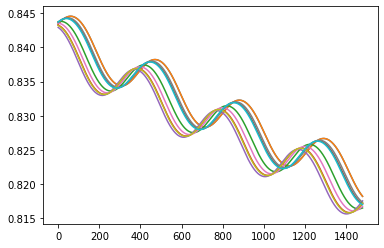